In [53]:
Соколов Данила Валерьевич БПИ161
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [54]:
data = pd.read_csv('train.tsv', sep = '\t')

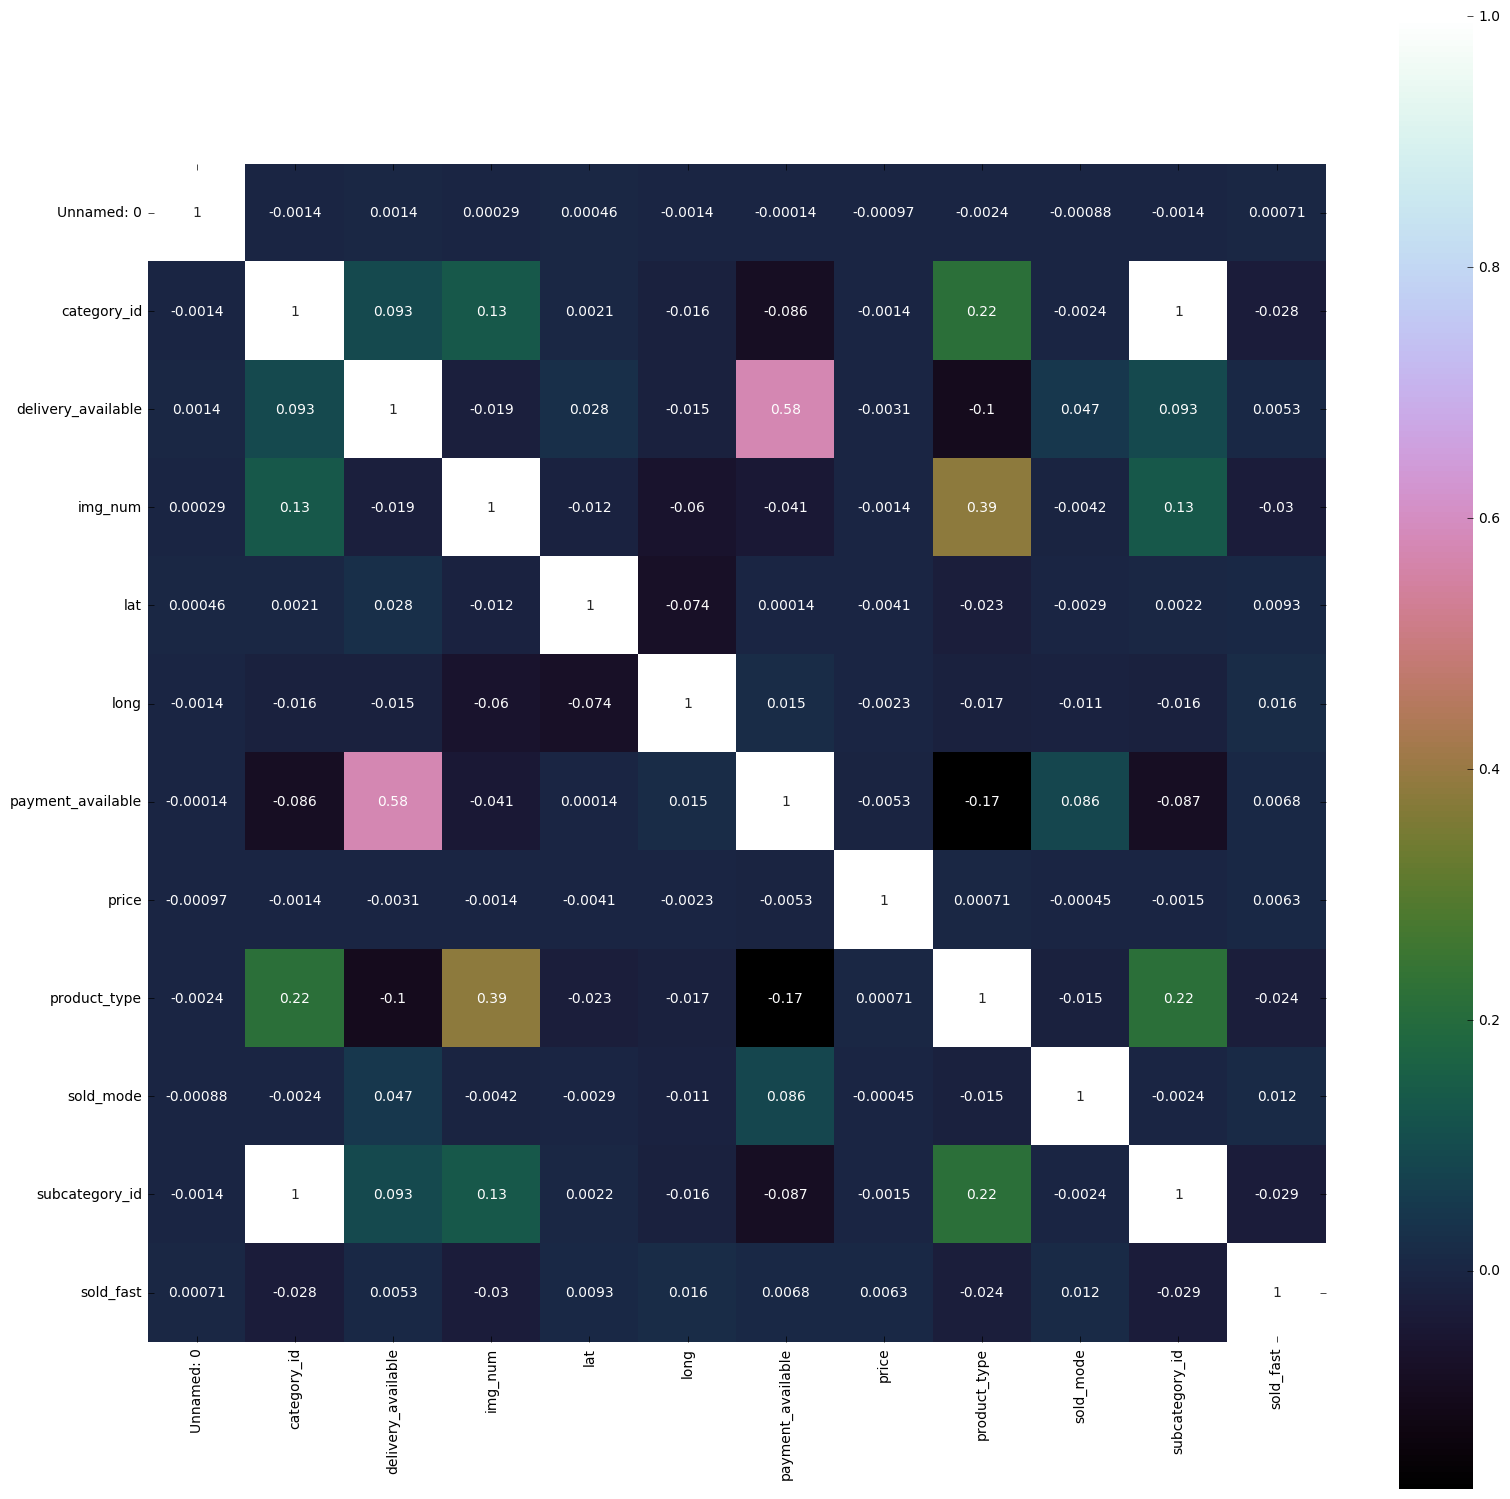

In [55]:
#корреляция между признаками
correlation = data.corr()
plt.figure(figsize=(19,19))
sns.heatmap(correlation, vmax = 1, square = True, annot = True, cmap = 'cubehelix')

In [56]:
from sklearn.model_selection import train_test_split

d_train, d_test = train_test_split(data, test_size=0.4, random_state=42)

y_train = d_train['sold_fast'].values
y_test = d_test['sold_fast'].values

In [57]:
def dateToInfo(date):
    dat = date.split('-')
    year = int(dat[0])
    month = int(dat[1])
    day = int(dat[2])
    s = year*365+month*30+day
    return [year, month, day, s]

In [58]:
def categoryDictionary(values, labels):
    category = {}
    for i in np.unique(values):
        l_i = labels[values == i]
        n = len(l_i)
        n_1 = len(l_i[l_i == 1])
        p = 1.0 * n_1 / n
        category[i] = p
    return category

In [59]:
def categoryProb(category, values):
    probability = []
    for i in values:
        if i in category:
            probability.append(category[i])
        else:
            probability.append(0)
    return np.array(probability)

In [60]:
from math import sin, cos, sqrt, atan2, radians
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from math import sin, cos, sqrt, atan2

#subcategory_id из обучения выкинул так как корреляция с category =|1|
#Также при обучении я попытался рассчитать с помощью lat long минимальное расстояние до ближайщего продающего от текущего
#В различных вариациях, как сумма расстояний, как минимальное расстояние и т.д.
#def calc_dist(data):
#    x4 = data[['lat','long']]
#    x5=[]
#    print(len(x4))
#    for i in x4.values:
#       distance = 100000
#        for j in x4.values:
#            R = 6373.0
#
#            lat1 = i[0]
#            lon1 = i[1]
#            lat2 = j[0]
#            lon2 = j[1]
#
#            dlon = lon2 - lon1
#            dlat = lat2 - lat1
#            a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
#            c = 2 * atan2(sqrt(a), sqrt(1-a))
#            d = R * c
#            if (d < distance):
#                distance = d;
#        x5.append(sqrt(distance)
#    return x5
   
#Оказалась очень медленной операцией и в итоге на результат практически не повлияла
                  

category_id_dict = categoryDictionary(d_train['category_id'].values, y_train)
city_dict = categoryDictionary(d_train['city'].values, y_train)
region_dict = categoryDictionary(d_train['region'].values, y_train)
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(d_train['category_id'].values.reshape(-1, 1))
                  
vectorize_name_test = TfidfVectorizer(max_features=100, decode_error='ignore')
vectorize_name_test.fit(d_train['name_text'].values)
                  
vectorize_desc_text = TfidfVectorizer(max_features=100, decode_error='ignore')
vectorize_desc_text.fit(d_train['desc_text'].values)

def preprocessing(data):
    al = data[['lat', 'long', 'price', 'product_type', 'img_num']].values
    date = np.array([dateToInfo(i) for i in data['date_created'].values])
    add = data[['payment_available', 'delivery_available']].values * 1.
    cities = categoryProb(city_dict, data['city'].values).reshape(-1, 1)
    regions = categoryProb(region_dict, data['region'].values).reshape(-1, 1)
    categories = ohe.transform(data['category_id'].values.reshape(-1, 1)).toarray()
    name_text = data['name_text'].values
    names = vectorizer_name_text.transform(name_text).toarray()
    desc_text = data['desc_text'].values
    descs = vectorizer_desc_text.transform(desc_text).toarray()
    
    return np.concatenate(tuple([al, date, add, cities, regions, categories, names, descs]), axis=1)

In [61]:
X_train = preprocessing(d_train)
X_test = preprocessing(d_test)

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

min_samples_leaf_range = [2, 5, 10, 15, 20, 25, 30, 40, 50]

results_cross_val = []

for i in min_samples_leaf_range:
    clf = RandomForestClassifier(n_estimators=100, n_jobs=4, class_weight='balanced', min_samples_leaf=i, oob_score=True)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict_proba(X_train)[:, 1]
    y_test_pred = clf.predict_proba(X_test)[:, 1]



    auc_train = roc_auc_score(y_train, y_train_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)
    
    results_cross_val.append(auc_test)
    print("Train AUC: ", auc_train)
    print("Test AUC: ", auc_test)

print(results_cross_val)
#Видно что при маленьком min_samples_leaf модель переобучается
#Данный вариант выбран мной как итоговый с n_estimatorss=1000 min_samples_leaf = 40

Train AUC:  0.998464232093
Test AUC:  0.614315235339
Train AUC:  0.966124042512
Test AUC:  0.620551924174
Train AUC:  0.888945306554
Test AUC:  0.622830680724
Train AUC:  0.833719368203
Test AUC:  0.624367428699
Train AUC:  0.796243534329
Test AUC:  0.625326150613
Train AUC:  0.770596530013
Test AUC:  0.625528180132
Train AUC:  0.752098229358
Test AUC:  0.624342635835
Train AUC:  0.726606522422
Test AUC:  0.624988156567
Train AUC:  0.709700502654
Test AUC:  0.624040479793
[0.61431523533949139, 0.6205519241736811, 0.62283068072409575, 0.62436742869870221, 0.62532615061314556, 0.6255281801320669, 0.62434263583523975, 0.62498815656708473, 0.6240404797929282]


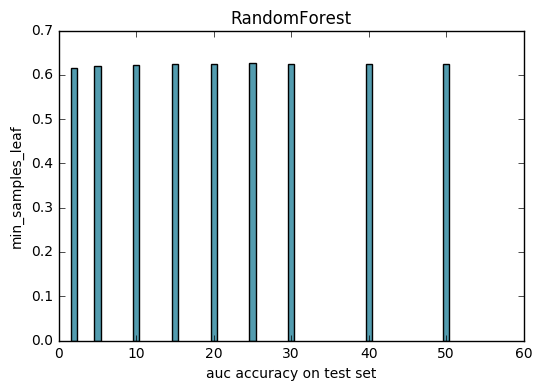

In [63]:
import numpy as np

#В целом в зависимости от параметра различия в районе тысячных

x = min_samples_leaf_range
y = results_cross_val

_, ax = plt.subplots()

ax.bar(x, y, color = '#539caf', align = 'center')


ax.errorbar(x, y, color = '#297083', ls = 'none', lw = 2, capthick = 2)
ax.set_ylabel('min_samples_leaf')
ax.set_xlabel('auc accuracy on test set')
ax.set_title('RandomForest')

In [64]:
C_param_range = [0.001,0.01,0.1,1,10,50]

resulted_accuracy = []

for i in C_param_range:
    clf = LogisticRegression(penalty = 'l1', C=i,random_state = 42)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict_proba(X_train)[:, 1]
    y_test_pred = clf.predict_proba(X_test)[:, 1]



    auc_train = roc_auc_score(y_train, y_train_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)
    resulted_accuracy.append(auc_test)
    print("Train AUC: ", auc_train)
    print("Test AUC: ", auc_test)
#Точность низкая, но при увеличении C до 100 точность близка с выбранным RandomForest(растет с увеличением C до порога полученного в предидущем)

/home/dani120k/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:  0.556795297421
Test AUC:  0.558688524813


/home/dani120k/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:  0.610609185615
Test AUC:  0.594391973173


/home/dani120k/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:  0.622654406904
Test AUC:  0.603587023075


/home/dani120k/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:  0.623439101337
Test AUC:  0.603606547293


/home/dani120k/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:  0.623443555098
Test AUC:  0.603490011405


/home/dani120k/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:  0.623410544426
Test AUC:  0.603672852942


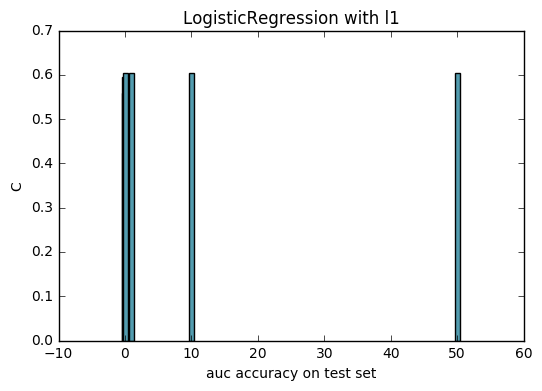

In [65]:
import numpy as np

x = C_param_range
y = resulted_accuracy

_, ax = plt.subplots()

ax.bar(x, y, color = '#539caf', align = 'center')


ax.errorbar(x, y, color = '#297083', ls = 'none', lw = 2, capthick = 2)
ax.set_ylabel('C')
ax.set_xlabel('auc accuracy on test set')
ax.set_title('LogisticRegression with l1')

In [66]:
l2_result = []

for i in C_param_range:
    clf = LogisticRegression(penalty = 'l2', C=i,random_state = 42)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict_proba(X_train)[:, 1]
    y_test_pred = clf.predict_proba(X_test)[:, 1]



    auc_train = roc_auc_score(y_train, y_train_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)
    l2_result.append(auc_test)
    print("Train AUC: ", auc_train)
    print("Test AUC: ", auc_test)

/home/dani120k/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:  0.498421128954
Test AUC:  0.494061352064


/home/dani120k/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:  0.498421128954
Test AUC:  0.494061352064


/home/dani120k/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:  0.498421128954
Test AUC:  0.494061352064


/home/dani120k/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:  0.498421128954
Test AUC:  0.494061352064


/home/dani120k/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:  0.498421128954
Test AUC:  0.494061352064


/home/dani120k/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:  0.498421128954
Test AUC:  0.494061352064


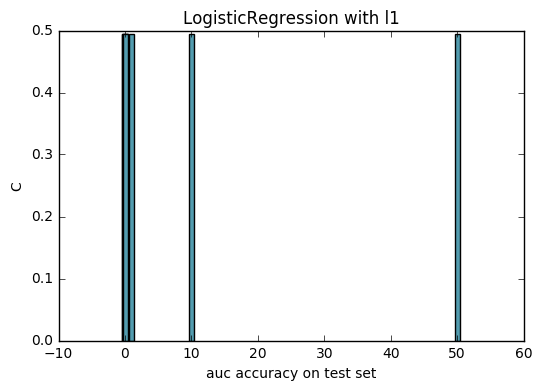

In [67]:
import numpy as np
#точность в принципе довольно низкая и скорее надо было больше поработать с фичами в этом конкретном случае

x = C_param_range
y = l2_result

_, ax = plt.subplots()

ax.bar(x, y, color = '#539caf', align = 'center')


ax.errorbar(x, y, color = '#297083', ls = 'none', lw = 2, capthick = 2)
ax.set_ylabel('C')
ax.set_xlabel('auc accuracy on test set')
ax.set_title('LogisticRegression with l1')

In [68]:
#запись ответа в итоговый файл
tested = pd.read_csv('test_nolabel.tsv', sep = '\t')
x_preproc = preprocessing(tested)

predict = clf.predict_proba(x_preproc)[:, 1]
product_id = tested['product_id'].values
tested = pd.DataFrame.from_dict({'product_id' : product_id, 'score' : predict})
tested.to_csv('./to_sub', sep = ',', index = False)